the dataset we have been using is taken form kaggle
https://www.kaggle.com/ronitf/heart-disease-uci

### predicting heart disease using machine learning

importing our tools

In [1]:
#importing data analysis and visualization tools
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

#importing scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Model evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
heart_data = pd.read_csv("heart-disease-data.csv")
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


there are two category in target, so we check the count

In [3]:
heart_data["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

check is there any missing value in the dataframe

In [4]:
heart_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
#finding the gender count
heart_data["sex"].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [6]:
#comparing the gender with number of patients who has heart disease
pd.crosstab(heart_data["target"],heart_data["sex"])

sex,0,1
target,,
0,24,114
1,72,93


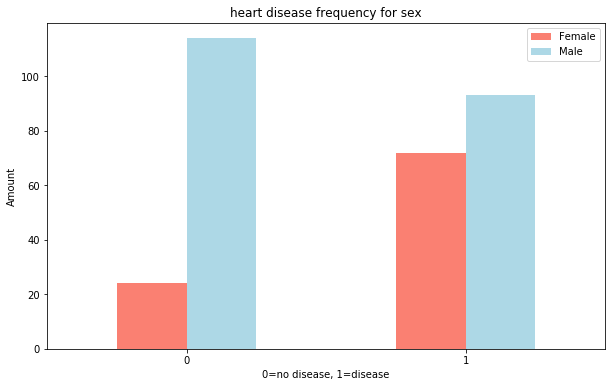

In [7]:
#visualizing the gender who has heart disease
pd.crosstab(heart_data["target"],heart_data["sex"]).plot(kind='bar',
                                                        figsize=(10,6),
                                                        color=['salmon','lightblue']);
plt.title("heart disease frequency for sex")
plt.xlabel("0=no disease, 1=disease")
plt.ylabel("Amount")
plt.legend(["Female","Male"]);
plt.xticks(rotation=0);

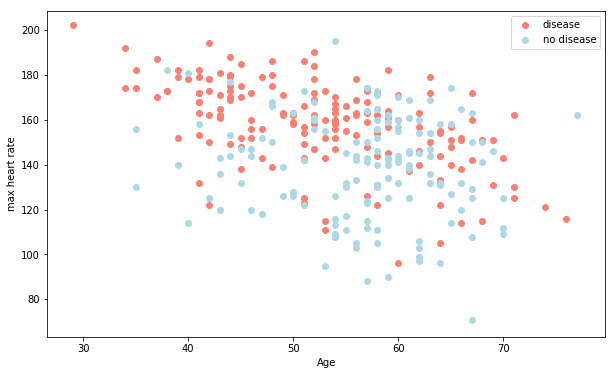

In [8]:
plt.figure(figsize=(10,6))

#scatter with positive examples(the person who have heart disease)
plt.scatter(heart_data.age[heart_data.target==1],
        heart_data.thalach[heart_data.target==1],
        c='salmon');

#scatter with negative data(person who dont have heart disease)
plt.scatter(heart_data.age[heart_data.target==0],
        heart_data.thalach[heart_data.target==0],
        c='lightblue');
plt.xlabel("Age")
plt.ylabel("max heart rate")
plt.legend(["disease","no disease"]);

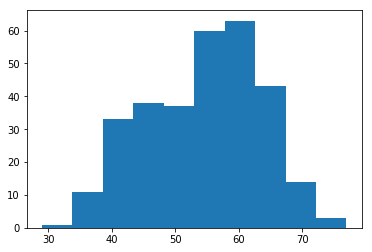

In [9]:
#we are seeing the distribution of age
plt.hist(heart_data["age"]);

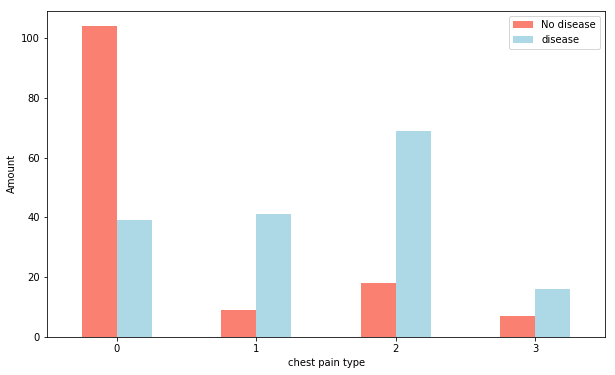

In [10]:
#Heart disease frequency by chest pain type
pd.crosstab(heart_data.cp,heart_data.target).plot(kind='bar',
                                                 figsize=(10,6),
                                                 color=["salmon","lightblue"])

plt.xlabel("chest pain type")
plt.ylabel("Amount")
plt.legend(["No disease","disease"])
plt.xticks(rotation=0);

In [11]:
#splitting data into x and y, where x has feautures and y has labels

x = heart_data.drop("target",axis=1)
y = heart_data["target"]

In [12]:
#now our x wont have target 
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [13]:
#y will have all the labels
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

### splitting data into train and test sets

In [14]:
np.random.seed(42)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

It is difficult to find which model is good for our machine learning model, so we created a function named `fit_and_score()`
which will take different models and calculate its accuracy and returns the score of all models.

In [15]:
model_dict = {
    "Logistic Regression":LogisticRegression(),
    "KNN":KNeighborsClassifier(),
    "Random forest":RandomForestClassifier()
}

def fit_and_score(models,x_train,x_test,y_train,y_test):
    np.random.seed(42)
    model_scores = dict()
    for name,model in model_dict.items():
        model.fit(x_train,y_train)
        model_scores[name] = model.score(x_test,y_test)
    
    return model_scores

In [16]:
model_sc = fit_and_score(model_dict,x_train,x_test,y_train,y_test);
model_sc

c:\users\akash\miniconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.6885245901639344,
 'Logistic Regression': 0.8852459016393442,
 'Random forest': 0.8360655737704918}

Now we got our baseline model, but to improve its accuracy we need to tune its hyperparameters

### hypertuning for knn model

In [17]:
knn_clf = KNeighborsClassifier()
knn_train_scores = []
knn_test_scores = []

for i in range(1,21):
    #tuning hyperparameter(changing the n_neighbor)
    knn_clf.set_params(n_neighbors=i)
    
    #fiting our training data
    knn_clf.fit(x_train,y_train)
    #getting the score
    knn_train_scores.append(knn_clf.score(x_train,y_train))
    knn_test_scores.append(knn_clf.score(x_test,y_test))

In [18]:
knn_test_scores.index(max(knn_test_scores)),max(knn_test_scores)

(10, 0.7540983606557377)

after tuning our knn model we got the maximum score of 0.75 for n_neighbors=10.But it is faraway from the baseline scores of other models.so for this problem knn is not the best way. So we move on to next model

In [19]:
#creating hyperparameter grid for Logisticregression
lr_grid = {"C":np.logspace(-4,4,20),
          "solver":["liblinear"]}
#creating hyperparameters for random forest grid
rf_grid = {
    "n_estimators":[10,100,200,500,1000,1200],
    "max_depth":[None,5,10,20,30],
    "max_features":["auto","sqrt"],
    "min_samples_split":[2,4,6],
    "min_samples_leaf":[1,2,4]
}

### Hyperparameter Tuning with RandomizedSearchCv

In [20]:
#Tune logistic regression
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=lr_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True);

#fitting data into the model
rs_log_reg.fit(x_train,y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished


In [21]:
#now we check the best parameters for our model
rs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [22]:
rs_log_reg.score(x_test,y_test)

0.8852459016393442

there is no difference between the baseline lg model and tuned lg model so we train the rf model

In [23]:
#Tuning randomforest model
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter = 20,
                          verbose=True);

rs_rf.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [24]:
rs_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [25]:
rs_rf.score(x_test,y_test)

0.8688524590163934

### Hyperparameter Tuning with GridSearchcv

In [26]:
#tuning lg model using Grid search cv
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=lr_grid,
                         cv=5,
                         verbose=True)

#fit grid hyperparameter search model
gs_log_reg.fit(x_train,y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [29]:
#checking best hyperparameters
print(gs_log_reg.best_params_)

#checking score
gs_log_reg.score(x_test,y_test)

{'C': 0.23357214690901212, 'solver': 'liblinear'}


0.8852459016393442

so after also tuning our model we get the same score, so we move on with this model itself.

## Evaluating the model

### consfusion matrix

In [39]:
y_preds = gs_log_reg.predict(x_test)
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [40]:
confusion_matrix(y_test,y_preds)

array([[25,  4],
       [ 3, 29]], dtype=int64)

Text(3.5, 0.5, 'Predicted label')

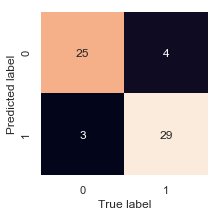

In [46]:
#plotting confusion matrix
sns.set(font_scale=1)

fig,ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                annot=True,
                cbar=False)

plt.xlabel("True label")
plt.ylabel("Predicted label")

ROC CURVE

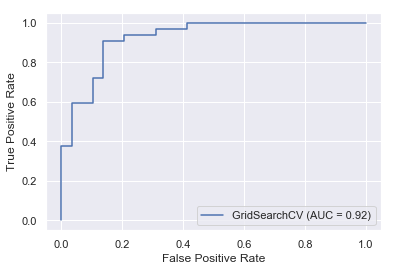

In [47]:
plot_roc_curve(gs_log_reg,x_test,y_test)

our model got auc score of 0.92 which is good

### classification report

In [48]:
print(classification_report(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.91      0.88      0.89        33

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



In [49]:
f1_score(y_preds,y_test)

0.8923076923076922

### calculate evaluation metrics using `cross_validation()`

In [50]:
#instantiating the model
clf = LogisticRegression(C=0.23357214690901212,
                         solver='liblinear')

In [52]:
#cross validated accuracy
cv_accuracy = cross_val_score(clf,
                              x,
                              y,
                              cv=5,
                              scoring='accuracy')

np.mean(cv_accuracy)

0.8479781420765027

In [53]:
#cross validated prescision
cv_precision = cross_val_score(clf,
                              x,
                              y,
                              cv=5,
                              scoring='precision')

np.mean(cv_precision)

0.8215873015873015

In [54]:
#cross validated recall score
cv_recall = cross_val_score(clf,
                              x,
                              y,
                              cv=5,
                              scoring='recall')

np.mean(cv_recall)

0.9272727272727274

In [55]:
#cross validated f1 score
cv_f1 = cross_val_score(clf,
                              x,
                              y,
                              cv=5,
                              scoring='f1')

np.mean(cv_f1)

0.8705403543192143

## Feauture importance

feauture importance says which feauture has contributed most for the result of the model

In [64]:
clf = LogisticRegression(C=0.23357214690901212,
                         solver='liblinear')

clf.fit(x_train,y_train);

In [65]:
clf.coef_

array([[ 0.00369922, -0.90424085,  0.67472828, -0.0116134 , -0.00170364,
         0.04787689,  0.33490184,  0.02472939, -0.63120401, -0.57590906,
         0.47095113, -0.65165351, -0.699842  ]])

In [69]:
feature_dict = dict(zip(heart_data.columns,list(clf.coef_[0])))
feature_dict

{'age': 0.003699218314634231,
 'ca': -0.6516535125690047,
 'chol': -0.0017036448048050072,
 'cp': 0.6747282826858118,
 'exang': -0.6312040056168838,
 'fbs': 0.04787689050301493,
 'oldpeak': -0.5759090611742839,
 'restecg': 0.33490183888358416,
 'sex': -0.9042408481315317,
 'slope': 0.47095113183576787,
 'thal': -0.6998419969792693,
 'thalach': 0.024729385199310817,
 'trestbps': -0.011613404239724763}

In [77]:
print(max(feature_dict,key=lambda x:feature_dict[x]))

cp


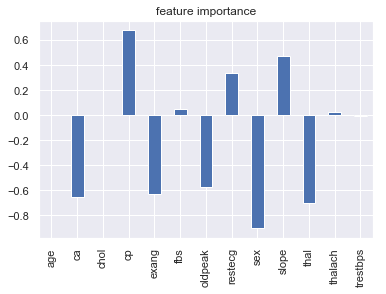

In [76]:
feature_graph = pd.DataFrame(feature_dict,index=[0])
feature_graph.T.plot.bar(title='feature importance',legend=False);

* chest pain feature contributed the most
* sex feature contributed the less